# Data set
## [A Large Scale Fish Dataset](https://www.kaggle.com/crowww/a-large-scale-fish-dataset)

## imports
ขั้นตอนแรก import library จะใช้

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2

## pre data
ขั้นตอนนี้จะทำการเตรียมข้อมูลที่อยู่ในfolderให้มาอยู่ในรูปแบบของDataframe

In [2]:
path =  Path("C:\\Users\\Nattakorn\\Desktop\\fish_project\\Fish_Dataset")
fish_path = list(path.glob(r'**/*.png'))
fish_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], fish_path))

In [3]:
fish_path = pd.Series(fish_path,name='path').astype('str')
fish_labels = pd.Series(fish_labels,name='Label').astype('str')
df = pd.concat([fish_path,fish_labels],axis=1)
df.head()

,path,Label
0,C:\Users\Nattakorn\Desktop\fish_project\Fish_D...,Black Sea Sprat
1,C:\Users\Nattakorn\Desktop\fish_project\Fish_D...,Black Sea Sprat
2,C:\Users\Nattakorn\Desktop\fish_project\Fish_D...,Black Sea Sprat
3,C:\Users\Nattakorn\Desktop\fish_project\Fish_D...,Black Sea Sprat
4,C:\Users\Nattakorn\Desktop\fish_project\Fish_D...,Black Sea Sprat


ในDataframeก็จะมีcolum (path,Label) pathระบุที่อยู่ของรูปและมี Labelระบุประเภทของสัตว์ที่ของในรูป

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    18000 non-null  object
 1   Label   18000 non-null  object
dtypes: object(2)
memory usage: 281.4+ KB


In [5]:
df['Label'].value_counts()

Black Sea Sprat          1000
Black Sea Sprat GT       1000
Trout                    1000
Striped Red Mullet GT    1000
Striped Red Mullet       1000
Shrimp GT                1000
Shrimp                   1000
Sea Bass GT              1000
Sea Bass                 1000
Red Sea Bream GT         1000
Red Sea Bream            1000
Red Mullet GT            1000
Red Mullet               1000
Hourse Mackerel GT       1000
Hourse Mackerel          1000
Gilt-Head Bream GT       1000
Gilt-Head Bream          1000
Trout GT                 1000
Name: Label, dtype: int64

In [6]:
df = df.loc[[x[-2:] != 'GT' for x in df['Label']]]

## Train test split

In [7]:
df_train , df_test = train_test_split(df,test_size=0.2,random_state=42) # train 80 test 20
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

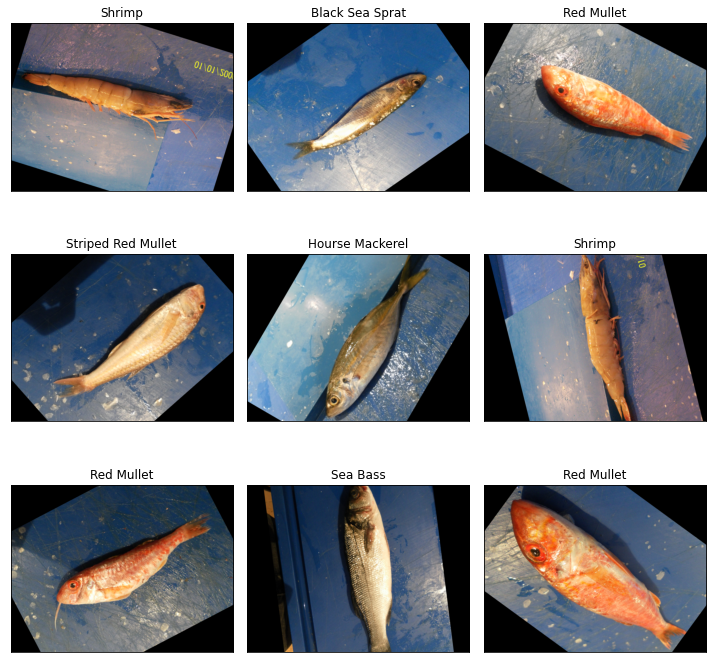

In [55]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_train.path[idx]))
    ax.set_title(df_train.Label[idx])
plt.tight_layout()
plt.show()

## image file to array

In [10]:
def img_array(data):
    arr = np.array([cv2.imread(x) for x in data])
    arr = list(map(lambda x: cv2.resize(x, dsize=(224, 224), interpolation=cv2.INTER_CUBIC),arr)) # resize to 224 x 224
    return np.array(arr)

In [11]:
x_train = img_array(df_train.path)
x_test = img_array(df_test.path)
x_train = x_train / 255
x_test = x_test /255

In [12]:
print(f'train: {x_train.shape}')
print(f'test: {x_test.shape}')

train: (7200, 224, 224, 3)
test: (1800, 224, 224, 3)


## dictionary for Label

In [25]:
dic_label_encode = {}
dic_label_decode = {}
for x,y in enumerate(df_test.Label.unique()):
    dic_label_encode[y] = x
    dic_label_decode[x] = y
print(f'dic_label_encode: \n{dic_label_encode}\n')
print(f'dic_label_encode: \n{dic_label_decode}\n')

dic_label_encode: 
{'Striped Red Mullet': 0, 'Gilt-Head Bream': 1, 'Black Sea Sprat': 2, 'Red Sea Bream': 3, 'Trout': 4, 'Sea Bass': 5, 'Red Mullet': 6, 'Shrimp': 7, 'Hourse Mackerel': 8}

dic_label_encode: 
{0: 'Striped Red Mullet', 1: 'Gilt-Head Bream', 2: 'Black Sea Sprat', 3: 'Red Sea Bream', 4: 'Trout', 5: 'Sea Bass', 6: 'Red Mullet', 7: 'Shrimp', 8: 'Hourse Mackerel'}



## one hot encoding

In [14]:
y_train = tf.keras.utils.to_categorical([dic_label[x] for x in df_train.Label])
y_test = tf.keras.utils.to_categorical([dic_label[x] for x in df_test.Label])

## tranferlearing with model MobileNetV2

In [15]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


## traning model

In [16]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
history = model.fit(x=x_train,y=y_train,epochs=10,
    validation_data=(x_test,y_test),
    callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=1,
                restore_best_weights=True
            )
        ]
    )

Epoch 1/10
225/225 [==============================] - 166s 738ms/step - loss: 0.2514 - accuracy: 0.9215 - val_loss: 0.0688 - val_accuracy: 0.9733
Epoch 2/10
225/225 [==============================] - 156s 692ms/step - loss: 0.0218 - accuracy: 0.9939 - val_loss: 0.0346 - val_accuracy: 0.9894
Epoch 3/10
225/225 [==============================] - 156s 693ms/step - loss: 0.0308 - accuracy: 0.9921 - val_loss: 0.0168 - val_accuracy: 0.9944
Epoch 4/10
225/225 [==============================] - 159s 709ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.0139 - val_accuracy: 0.9956
Epoch 5/10
225/225 [==============================] - 155s 687ms/step - loss: 0.0024 - accuracy: 0.9999 - val_loss: 0.0492 - val_accuracy: 0.9822


เนื้องจากใช้GPUไม่ได้ไม่รู้เพราะอะไรจึงเหลือ2ทางเลือก colab / ใช้cpu train model <br>
**สรุป** ก็เลือกtrainบนเครื่องมันนี้เหละ!

 cpu using **100**%  <img src="cpu100.jpg"/>

### accuracy test

In [19]:
result = model.predict(x_test)
accuracy = sum(result.argmax(axis=1) == y_test.argmax(axis=1)) / len(y_test)
print(f'model accuracy {accuracy*100:.2f}%')

model accuracy 99.56%


## หน้าตาของปลาที่โมเดลทำนายผิด
ผลของการprediction จากtest set 1800รูป<br>
ทำนาย ถูก 1792 รูป ผิด 8 รูป<br>
1. Gilt-Head Bream 2
2. Hourse Mackerel 2
3. Striped Red Mullet 2
4. Red Sea Bream 1
5. Sea Bass 1

In [33]:
df_test['predic'] = predic

In [26]:
predic = result.argmax(axis=1)
predic = [dic_label_decode[x] for x in predic]

In [41]:
false_pred = df_test.loc[df_test['Label'] != df_test['predic']]
false_pred.reset_index(drop=True,inplace=True)

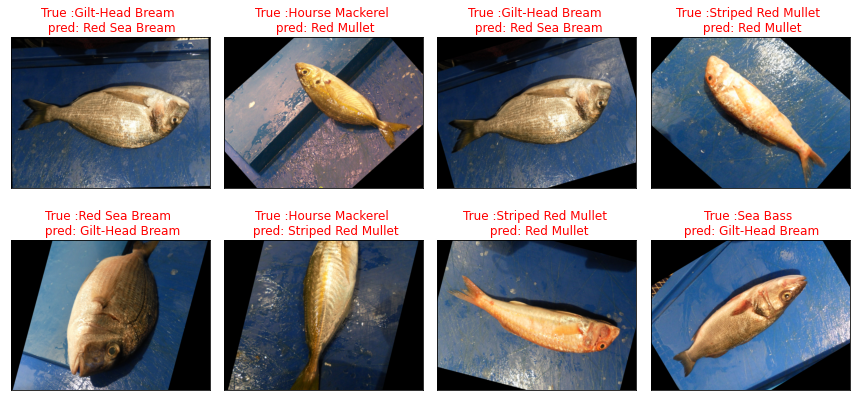

In [51]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), subplot_kw={'xticks': [], 'yticks': []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(false_pred.path[idx]))
    color = ['g' if false_pred.Label[idx] == false_pred.predic[idx] else 'r']
    ax.set_title(f'True :{false_pred.Label[idx]} \n pred: {false_pred.predic[idx]}',color=color[0])
plt.tight_layout()
plt.show()

### ลืมsave model....
สิ่งที่สำคัญดันลืมแย่จริงๆ